In [ ]:
import os

import torch
from torch.backends import cudnn
from torchvision.io import read_video, read_image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import *

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(torch.cuda.get_device_properties(0))
print(cudnn.is_available())
a = torch.tensor(1.)
a.cuda(device='cuda:1')

_CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
True


tensor(1., device='cuda:1')

In [3]:
import os

In [31]:
# from scipy.io import loadmat
import h5py

ROOT = '/home/wangyh/02-Datasets/Z-NLOS'
PATH = os.path.join(ROOT, os.listdir(ROOT)[0])

file = h5py.File(PATH, mode='r')
for key in file.keys():
    print(file[key], '\n')

<HDF5 dataset "cameraGridNormals": shape (3, 256), type "<f4"> 

<HDF5 dataset "cameraGridPoints": shape (1, 2), type "<f4"> 

<HDF5 dataset "cameraGridPositions": shape (3, 256), type "<f4"> 

<HDF5 dataset "cameraGridSize": shape (1, 2), type "<f8"> 

<HDF5 dataset "cameraPosition": shape (3, 1), type "<f8"> 

<HDF5 dataset "data": shape (1024, 6, 256, 256), type "<f4"> 

<HDF5 dataset "deltaT": shape (1, 1), type "<f8"> 

<HDF5 dataset "hiddenVolumePosition": shape (3, 1), type "<f8"> 

<HDF5 dataset "hiddenVolumeRotation": shape (3, 1), type "<f8"> 

<HDF5 dataset "hiddenVolumeSize": shape (1, 1), type "<f8"> 

<HDF5 dataset "isConfocal": shape (1, 1), type "<i8"> 

<HDF5 dataset "laserGridNormals": shape (3, 256), type "<f4"> 

<HDF5 dataset "laserGridPoints": shape (1, 2), type "<f4"> 

<HDF5 dataset "laserGridPositions": shape (3, 256), type "<f4"> 

<HDF5 dataset "laserGridSize": shape (1, 2), type "<f8"> 

<HDF5 dataset "laserPosition": shape (3, 1), type "<f8"> 

<HDF5 datase

In [32]:
file['isConfocal'][:]

array([[0]])

In [33]:
bunny_data = file['data'][:]
bunny_data.shape  # (N_POINTS_X , N_POINTS_Y , BOUNCES , TIME_RES)

(1024, 6, 256, 256)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rcParams['figure.figsize'] = (50.0, 36.0)  # set default size of plots

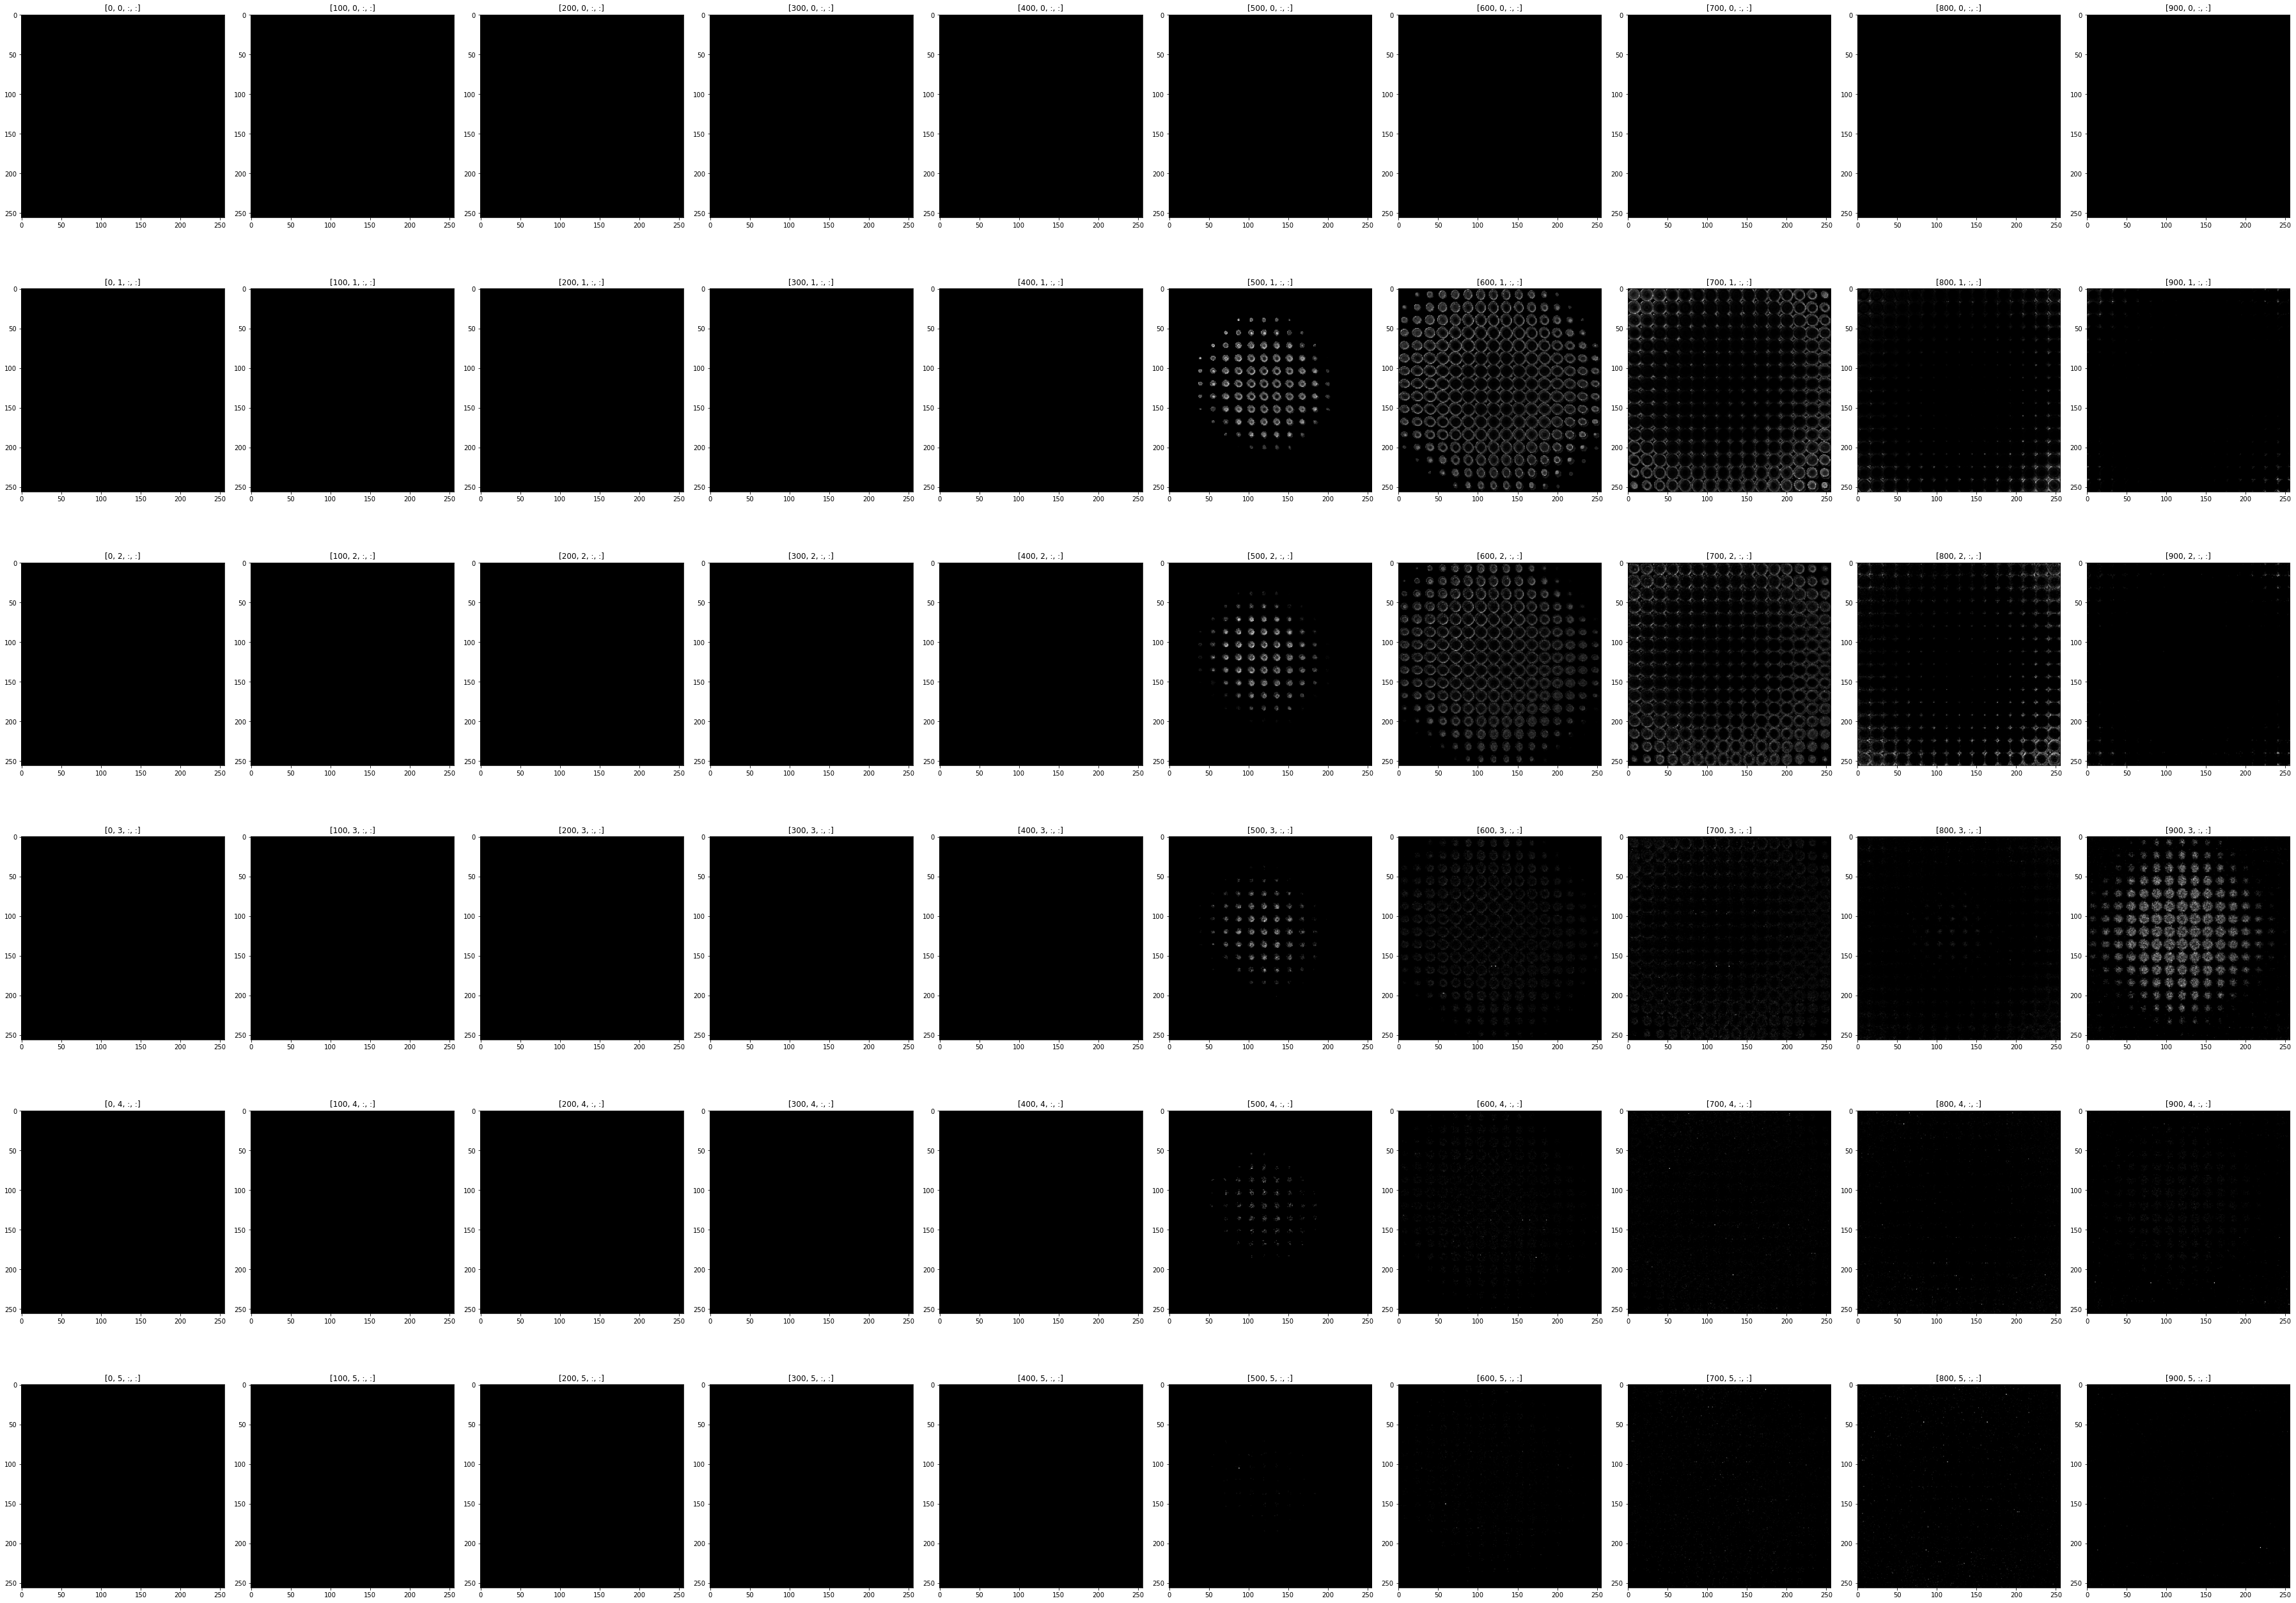

In [35]:
fig = plt.figure()
col_num, row_num = bunny_data.shape[0] // 100, bunny_data.shape[1]
for row in range(row_num):
    for col in range(col_num):
        plt.subplot(row_num, col_num, row * col_num + col + 1)
        plt.title(f"[{100 * col}, {row}, :, :]")
        plt.imshow(bunny_data[100 * col, row], cmap='gray')
plt.tight_layout()

In [5]:
video_dir = "/home/wangyh/02-Datasets/Videos"
video_path = os.listdir(video_dir)[0]
video_path = os.path.join(video_dir, video_path)
print(video_path)

/home/wangyh/02-Datasets/Videos/用【新海诚】的方式打开镰仓，进来被治愈吧！.mp4


In [6]:
import cv2

cap = cv2.VideoCapture(video_path)

tensor([[[0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         ...,
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061]],

        [[0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         ...,
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061]],

        [[0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         ...,
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061]],

        ...,

        [[0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         ...,
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061]],

        [[0.5137, 0.6587, 0.7061],
         [0.5137, 0.6587, 0.7061],
         [0.

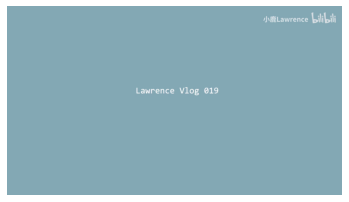

In [8]:
success, frame = cap.read()
if success:
    plt.imshow(frame)
    frame = torch.from_numpy(frame).type(torch.float16) / 255.
    print(frame)
    plt.axis("off")

In [9]:
fps = cap.get(cv2.CAP_PROP_FPS)
channels = 3
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_size = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), \
             int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [32]:
video = torch.zeros(frame_count, *frame_size, 3, dtype=torch.float16)
video.size()

torch.Size([5219, 1080, 1920, 3])

In [39]:
count = 0
while cap.isOpened():
    success, frame = cap.read()
    cv2.waitKey(20)
    frame = torch.from_numpy(frame).type(torch.float16) / 255.
    video[count] = frame
    print("\b", count)
    count += 1

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41
 42
 43
 44
 45
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57
 58
 59
 60
 61
 62
 63
 64
 65
 66
 67
 68
 69
 70
 71
 72
 73
 74
 75
 76
 77
 78
 79
 80
 81
 82
 83
 84
 85
 86
 87
 88
 89
 90
 91
 92
 93
 94
 95
 96
 97
 98
 99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110
 111
 112
 113
 114
 115
 116
 117
 118
 119
 120
 121
 122
 123
 124
 125
 126
 127
 128
 129
 130
 131
 132
 133
 134
 135
 136
 137
 138
 139
 140
 141
 142
 143
 144
 145
 146
 147
 148
 149
 150
 151
 152
 153
 154
 155
 156
 157
 158
 159
 160
 161
 162
 163
 164
 165
 166
 167
 168
 169
 170
 171
 172
 173
 174
 175
 176
 177
 178
 179
 180
 181
 182
 183
 184
 185
 186
 187
 188
 189
 190
 191
 192
 193
 194
 195
 196
 197
 198
 199
 200
 201
 202
 203
 204
 205
 206
 207
 208
 209
 210
 211
 212
 213
 214
 215
 216
 217
 218
 219
 220
 221


KeyboardInterrupt: 

In [57]:
from torchvision.io import read_video
from loader.load_video import load_video

In [58]:
vframes, aframes, info = load_video(video_path, end_pts=3)
vframes.size()

TypeError: load_video() got an unexpected keyword argument 'end_pts'

In [48]:
# vframes, aframes, info = load_video(video_path)
vframe = vframes[0]
vframe

tensor([[[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
         [180, 168, 131],
         [180, 168, 131]],

        [[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
         [180, 168, 131],
         [180, 168, 131]],

        [[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
         [180, 168, 131],
         [180, 168, 131]],

        ...,

        [[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
         [180, 168, 131],
         [180, 168, 131]],

        [[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
         [180, 168, 131],
         [180, 168, 131]],

        [[180, 168, 131],
         [180, 168, 131],
         [180, 168, 131],
         ...,
         [180, 168, 131],
        

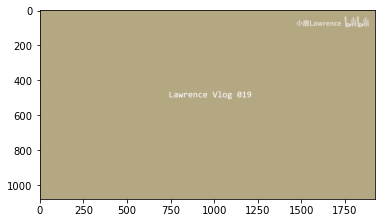

In [42]:
plt.imshow(vframe)

In [33]:
torch.max(vframes[0])

tensor(255, dtype=torch.uint8)

In [96]:
root = "/home/wangyh/01-Projects/04-blender/blank_wall/output_dance"
print(len(os.listdir(root)))
frame_range = sorted(os.listdir(root))[0: 500]
frame_paths = [os.path.join(root, f) for f in frame_range]
frame_paths

952


['/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0250.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0251.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0252.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0253.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0254.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0255.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0256.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0257.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0258.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0259.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0260.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0261.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/output_dance/0262.png',
 '/home/wangyh/01-Projects/04-blender/blank_wall/ou

(3, 1080, 1920)

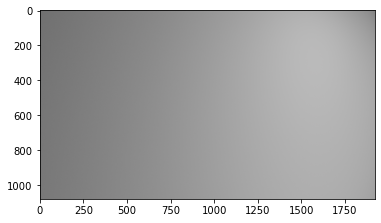

In [28]:
frame = read_image(frame_paths[0])
plt.imshow(frame.permute(1, 2, 0))
C, H, W = frame.shape
C, H, W

In [1]:
from Loader.loader import load_frames
from Loader.preprocessor import preprocess_frames

In [5]:
device = torch.device(f"cuda:{2}")
frames = load_frames(root="/home/wangyh/01-Projects/04-blender/blank_wall/output_dance",
                     frame_range=(0, 500)).to(device)

In [6]:
frames.shape

torch.Size([500, 1080, 1920, 3])

In [7]:
frames_sub_mean = preprocess_frames(frames)

In [9]:
frames_people = load_frames(root="/home/wangyh/01-Projects/04-blender/blank_wall/output_dance_people")

In [11]:
frames_people[0]

tensor([[[138., 138., 138.],
         [137., 137., 137.],
         [136., 136., 136.],
         ...,
         [170., 170., 170.],
         [170., 170., 170.],
         [171., 170., 170.]],

        [[135., 135., 135.],
         [138., 138., 138.],
         [138., 138., 138.],
         ...,
         [171., 171., 171.],
         [169., 169., 169.],
         [170., 170., 170.]],

        [[137., 137., 137.],
         [138., 138., 138.],
         [137., 137., 137.],
         ...,
         [168., 168., 168.],
         [172., 172., 172.],
         [171., 171., 171.]],

        ...,

        [[147., 147., 147.],
         [153., 153., 153.],
         [152., 152., 152.],
         ...,
         [176., 176., 176.],
         [176., 175., 176.],
         [175., 175., 175.]],

        [[153., 153., 153.],
         [149., 149., 149.],
         [150., 150., 150.],
         ...,
         [176., 176., 176.],
         [176., 176., 176.],
         [177., 177., 177.]],

        [[150., 150., 150.],
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


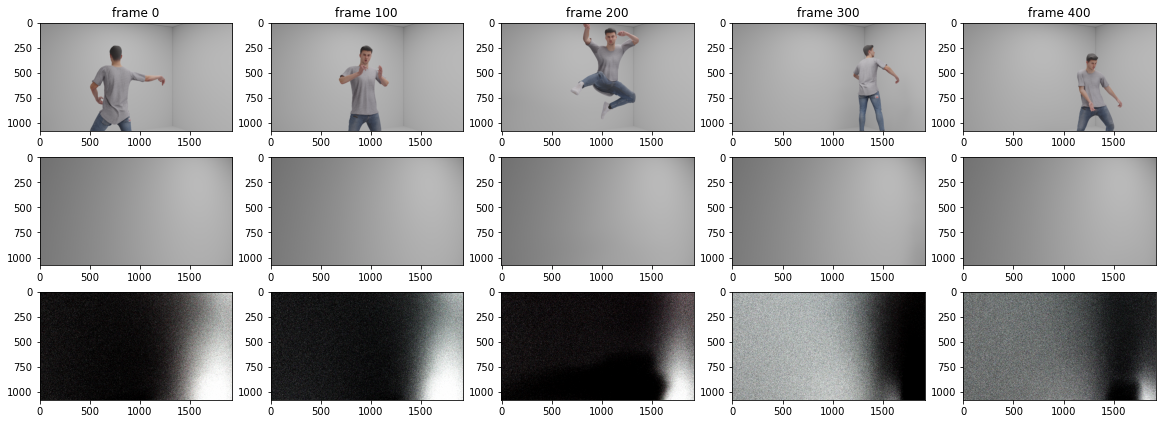

In [15]:
sample_num = 5
fig, axs = plt.subplots(3, sample_num, figsize=(4 * sample_num, 7))
for i in range(sample_num):
    idx = 100 * i
    axs[0, i].imshow(frames_people[i].cpu() / 255.)
    axs[0, i].set_title(f'frame {idx}')
    axs[1, i].imshow(frames[idx].cpu() / 255.)
    axs[2, i].imshow(frames_sub_mean[idx].cpu())

In [5]:
from torchvision.io import read_image

import matplotlib.pyplot as plt

In [2]:
img1 = read_image(path='./test/有家具.png')
img2 = read_image(path='./test/无家具.png')

(-0.5, 1023.5, 1023.5, -0.5)

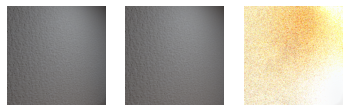

In [10]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img1[:3].permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img2[:3].permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((img1[:3]-img2[:3]).permute(1,2,0))
plt.axis('off')

In [11]:
import os
os.getcwd()

'/home/wangyh/01-Projects/01-NLOS'